# Brute-Force Combinatorial Optimization Sensor Selection

This notebook utilizes heuristic methods to solve the brute force combinatorial optimization problem for sensor selection based directly on estimation of the initial condition. Rather than constructing the observability matrix and maximizing its rank via sensor selection, we design the $C$ matrix to minimize the error in the estimate $\|x_0-\hat{x}_0\|$ where $\hat{x}_0$ comes from

$\begin{bmatrix}y_0\\ y_1\\ \vdots \\ y_t\end{bmatrix}=\begin{bmatrix}C\\ CA\\ \vdots \\ CA^t\end{bmatrix}\hat{x}_0$

$A$ is generated from DMD, and the outputs $y_0,\dots,y_t$ come from the data.

# Preamble and Imports

Cooper's code for imports and loading the data

In [1]:
pip install BIO

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
from importlib import reload
from scipy.stats import zscore
import scipy.io
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter as savgol 
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import leidenalg
import umap
import time
import gget
from sklearn import preprocessing
import Bio.KEGG as kg

from pydmd import DMD

import matplotlib.pyplot as plt
import seaborn as sns

# local imports
sys.path.append("../python/")

import utils as ut
reload(ut)

import hasnain_DMD
reload(hasnain_DMD)

<module 'hasnain_DMD' from '/home/jpic/DMD_gene/notebooks/../python/hasnain_DMD.py'>

In [13]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
from pydmd import DMD
from importlib import reload

# local imports
sys.path.append("../python/")

import utils as ut
reload(ut)

import hasnain_DMD
reload(hasnain_DMD)

<module 'hasnain_DMD' from '/home/jpic/DMD_gene/notebooks/../python/hasnain_DMD.py'>

In [14]:
# raw_path = f"/nfs/turbo/umms-indikar/shared/projects/time_series_rna/chen2015/RNA_pipeline_ouputs/chen2015_rna/countMatrix/counts.raw.txt"
# raw_path = f"/nfs/turbo/umms-indikar/shared/projects/time_series_rna/chen2015/RNA_pipeline_ouputs/chen2015_rna/countMatrix/counts.normalized.txt"
raw_path = f"/home/jpic/DMD_gene/data/chen2015normalized.txt"

""" Load the raw expression """
df = pd.read_csv(raw_path, index_col=0)
print(f"{df.shape=}")
df.head()

gene_names = df.index.to_list()
gene2idx = {}
i = 0
for gene in gene_names:
    gene2idx[gene] = i
    i += 1

df.shape=(19393, 18)


In [15]:
# build fold-change dataframe

def getFCFrame(df, cols):
    """A function to return a new dataframe with 
    foldchanges over the initial. Expects cols to be time-ordered
    and that cols[0] is the initial condition """
    df2 = df[cols].copy()

    x0 = cols[0] # initial condition
    
    for c in cols[1:]:
        df2[c] = (df2[c] + 1) /  (df2[x0] + 1)

    return df2[cols[1:]].copy()

def data2DMD(df):
    """A function to make DMD suitable data from the 2015 data"""
    a = [x for x in df.columns if "a" in x]
    b = [x for x in df.columns if "b" in x]

    dfa = getFCFrame(df, a)
    dfb = getFCFrame(df, b)

    dmd_data = np.asarray([dfa, dfb])
    dmd_data = np.swapaxes(dmd_data, 0, 2)
    dmd_data = np.swapaxes(dmd_data, 0, 1)

    return dmd_data


def getMuData(df):
    """A function to get the mean expression of each replicate at
    each time point """

    mu_data = df.copy()
    mu_data = mu_data.T

    mu_data = mu_data.reset_index(drop=False)
    mu_data['time'] = mu_data['index'].apply(lambda x: x.replace("a", "").replace("b", "").replace('S', ''))
    mu_data['time'] = mu_data['time'].astype(int)
    mu_data = mu_data.drop(columns=['index'])
    
    mu_data = mu_data.groupby('time').mean().reset_index(drop=False)
    mu_data = mu_data.sort_values(by='time')
    mu_data = mu_data.set_index('time')
    return mu_data
    

dmd_data = data2DMD(df)
print(f"{dmd_data.shape=}")


mu_data = getMuData(df)
mu_data.shape

mu_data.head()

dmd_data.shape=(19393, 8, 2)


geneName,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
time,,,,,,,,,,,,,,,,,,,,,
1,904.255300,0.0,0.00000,0.0,0.0,618.173865,0.00000,445.859880,520.671265,0.0,...,313.82265,255.286130,733.532935,600.28250,583.365780,411.42857,447.014695,519.454775,519.157735,427.827400
2,744.680870,0.0,1666.66665,0.0,0.0,565.749225,0.00000,709.925700,602.356080,0.0,...,818.10675,925.344575,479.041915,497.88137,630.112980,635.71430,575.179750,730.248050,674.988825,637.090750
3,425.531905,0.0,0.00000,0.0,0.0,646.570550,3333.33325,718.550950,535.674590,0.0,...,741.71570,655.986115,576.347305,628.53107,660.303875,842.85715,683.807450,626.040100,588.974535,691.964295
4,531.914890,0.0,0.00000,2500.0,0.0,539.536900,0.00000,447.186845,561.235840,0.0,...,458.86239,331.240540,830.838300,598.51694,484.028045,442.14285,658.799615,446.945085,520.274800,557.105650
5,585.106375,0.0,0.00000,0.0,0.0,480.559210,0.00000,565.950100,665.703500,0.0,...,793.84743,914.339315,336.826335,467.86724,595.052600,565.71430,578.305720,623.662730,641.197520,576.636905


In [16]:
rank = 8 # when None == optimal hard threshold  
exact = False # when false, this is exact DMD
dmd_res = hasnain_DMD.dmd(dmd_data, exact=exact, rank=rank)
print(dmd_res.keys())

print(f"{dmd_res['A'].shape=}")
print(f"{dmd_res['Atilde'].shape=}")
print(f"{dmd_res['u_r'].shape=}")
print(f"{dmd_res['L'].shape=}")
print(f"{dmd_res['W'].shape=}")
print(f"{dmd_res['Phi'].shape=}")
print(f"{dmd_res['amplitudes'][0].shape=}")

print('done')

dict_keys(['A', 'Atilde', 'rank', 'u_r', 'SVD', 'L', 'W', 'data_embedded', 'Phi', 'Phi_hat', 'amplitudes', 'n', 'm', 'r'])
dmd_res['A'].shape=(19393, 19393)
dmd_res['Atilde'].shape=(8, 8)
dmd_res['u_r'].shape=(19393, 8)
dmd_res['L'].shape=(8,)
dmd_res['W'].shape=(8, 8)
dmd_res['Phi'].shape=(19393, 8)
dmd_res['amplitudes'][0].shape=(8, 8)
done


### Outputs

This section generates the following outputs:
* `dmd_res['A']`: the DMD A matrix for all genes
* `gene_names`: a list of gene names to index into the DMD A matrix
* `dmd_data`: data formatted for `hasnain_DMD.dmd()`
* `gene2idx`: a map of gene name to DMD index

# KEGG Pathways

Extract gene sets for KEGG pathways

In [3]:
# Show images inline
from IPython.display import Image

# Standard library packages
import io
import os

# Import Biopython modules to interact with KEGG
from Bio import SeqIO
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser

In [ ]:
## pathway genes lookup
pathway = {}
result = REST.kegg_list('pathway','hsa').read()
pathwayParser = result.split('\n')
for pw in pathwayParser:
    pwInf = pw.split('\t')
    if len(pwInf) < 2: break
    gene = False
    geneSet = []
    pwResult = REST.kegg_get(pwInf[0]).read()
    # print(pwInf[0])
    # print(pwResult)
    pwResult = pwResult.split('\n')
    for r in pwResult:
        r = r.split()
        if len(r) == 0: continue
        if r[0] == "GENE":
            gene = True
            r.pop(0)
        if gene and (r[0] != "GENE" and not r[0].isdigit()):
            gene = False
        if gene:
            geneSet.append(r[1])
    pathway[pwInf[0]] = {}
    pathway[pwInf[0]]['Name'] = pwInf[1]
    pathway[pwInf[0]]['Genes'] = geneSet
    print(pathway[pwInf[0]]['Name'])

In [11]:
for k in pathway.keys():
    for idx in range(len(pathway[k]['Genes'])):
        pathway[k]['Genes'][idx] = pathway[k]['Genes'][idx][0:-1]

In [15]:
import json

# Serializing json
# json_object = json.dumps(pathway, indent = 4)  
# print(json_object) 

with open("/scratch/indikar_root/indikar0/jpic/keggHumanPathways.json", "w") as outfile: 
    json.dump(pathway, outfile, indent = 4)

### Outputs

This section generates the following outputs:
* `pathway`: a dictionary indexed by pathway kegg identifer. The dictionary has fields for the human readible name and for the genes associated with the pathway
* `/scratch/indikar_root/indikar0/jpic/keggHumanPathways.json`: The pathway dictionary written to a json file

# Sensor Selection

In [39]:
!pip install control
import control as ct

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 4.5 MB/s eta 0:00:00:00:0100:01
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [46]:
import numpy as np
from numpy import linalg

In [89]:
import json

with open('/scratch/indikar_root/indikar0/jpic/keggHumanPathways.json', 'r') as openfile:
    pathway = json.load(openfile)
    
# print(pathway.keys())
pwKey = 'hsa00534'

In [90]:
geneIdxs = [gene_names.index(gene) for gene in pathway[pwKey]['Genes'] if gene in gene_names]
numGenes = len(geneIdxs)
# print(geneIdxs)
# print(len(geneIdxs))
# print(len(pathway[pwKey]['Genes']))
# print(dmd_data[geneIdxs,:,:].shape)

pathway_data = dmd_data[geneIdxs,:,:]


rank = 8 # when None == optimal hard threshold  
exact = False # when false, this is exact DMD

dmd = hasnain_DMD.dmd(pathway_data, exact=exact, rank=rank)
print(dmd.keys())

print(f"{dmd['A'].shape=}")
print(f"{dmd['Atilde'].shape=}")
print(f"{dmd['u_r'].shape=}")
print(f"{dmd['L'].shape=}")
print(f"{dmd['W'].shape=}")
print(f"{dmd['Phi'].shape=}")
print(f"{dmd['amplitudes'][0].shape=}")

print('done')

dict_keys(['A', 'Atilde', 'rank', 'u_r', 'SVD', 'L', 'W', 'data_embedded', 'Phi', 'Phi_hat', 'amplitudes', 'n', 'm', 'r'])
dmd['A'].shape=(24, 24)
dmd['Atilde'].shape=(8, 8)
dmd['u_r'].shape=(24, 8)
dmd['L'].shape=(8,)
dmd['W'].shape=(8, 8)
dmd['Phi'].shape=(24, 8)
dmd['amplitudes'][0].shape=(8, 8)
done


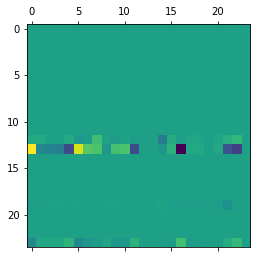

In [91]:
from matplotlib import pyplot as plt
plt.matshow(dmd['A'])

In [92]:
Osensors = {}
for idx in range(numGenes):
    Cmat = np.zeros((1,numGenes))
    Cmat[0,idx] = 1
    Ogene = ct.obsv(dmd['A'], Cmat)
    Osensors[pathway[pwKey]['Genes'][idx]] = {}
    Osensors[pathway[pwKey]['Genes'][idx]]['Omat'] = Ogene
    Osensors[pathway[pwKey]['Genes'][idx]]['rank'] = np.linalg.matrix_rank(Ogene)
    # print(O[pathway[pwKey]['Genes'][idx]]['rank'])

In [93]:
# Greedy Sensor selection
O = []
maxRank = 0
sensors = []
for gene in Osensors.keys():
    r = Osensors[gene]['rank']
    if r > maxRank:
        maxRank = r
        sensors = [gene]

O = Osensors[sensors[0]]['Omat']
remainingGenes = list(Osensors.keys())
remainingGenes.remove(sensors[0])
while np.linalg.matrix_rank(O) < numGenes:
    maxRank = 0
    nextSensor = ''
    for gene in remainingGenes:
        newRank = np.linalg.matrix_rank(np.vstack((O, Osensors[gene]['Omat'])))
        if newRank > maxRank:
            maxRank = newRank
            nextSensor = gene
    remainingGenes.remove(nextSensor)
    sensors.append(nextSensor)
    O = np.vstack((O, Osensors[nextSensor]['Omat']))
    print("New Sensor: " + str(nextSensor) + ", rank: " + str(maxRank))
                           
        

New Sensor: XYLT2, rank: 10
New Sensor: B4GALT7, rank: 11
New Sensor: B3GALT6, rank: 12
New Sensor: B3GAT3, rank: 13
New Sensor: EXTL2, rank: 14
New Sensor: EXTL3, rank: 15
New Sensor: EXTL1, rank: 16
New Sensor: EXT1, rank: 17
New Sensor: EXT2, rank: 18
New Sensor: NDST1, rank: 19
New Sensor: NDST2, rank: 20
New Sensor: NDST3, rank: 21
New Sensor: NDST4, rank: 22
New Sensor: HS6ST2, rank: 23
New Sensor: HS6ST3, rank: 24


In [82]:
(numGenes)

97

In [75]:
np.vstack((O, Osensors[gene]['Omat'])).shape

(194, 97)

In [77]:
O.shape

(8439, 97)

In [72]:
Osensors[gene]['Omat'].shape

(97, 97)

In [48]:
O = []

{'PI4KA': {'Omat': array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.00942775,  0.00884669,  0.007182  , ..., -0.02637983,
           0.01045918,  0.01463424],
         [ 0.0106134 ,  0.01232998,  0.01063871, ..., -0.00852558,
           0.00976887,  0.01231746],
         ...,
         [ 0.00249074,  0.00267594,  0.00206286, ..., -0.00186459,
           0.00237363,  0.00281235],
         [ 0.00245319,  0.0026356 ,  0.00203177, ..., -0.00183648,
           0.00233785,  0.00276995],
         [ 0.0024162 ,  0.00259586,  0.00200114, ..., -0.0018088 ,
           0.0023026 ,  0.0027282 ]]),
  'rank': 9},
 'PI4KB': {'Omat': array([[ 0.        ,  1.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.01101968,  0.00963943,  0.00696814, ..., -0.03009111,
           0.01247138,  0.0167858 ],
         [ 0.01230299,  0.0146485 ,  0.01290326, ..., -0.00866564,
           0.01112018,  0.01408789],


In [37]:
Cmat = np.zeros((1,numGenes))
Cmat[0,1] = 1
Cmat

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]])

## Select Most Entropic Pathways

For each KEGG pathway, determine the pathway activity by looking at entropy

In [26]:
# deep copy A
A = dmd_res['A'].copy()

In [33]:
genes = pathway['hsa00290']['Genes'].copy()
for i in range(len(genes)):                # remove this line
    genes[i] = genes[i][0:len(genes[i])-1] # remove this line
idxs = []
# print(genes)                               # remove this line
# print(pathway['hsa00290']['Genes'])        # remove this line
for gene in genes:
    print(gene)                            # remove this line
    idxs.append(gene2idx[gene])
# print(idxs)                                # remove this line
A1 = A[idxs,:]
Ap = A1[:,idxs]
print(Ap)

SDS
SDSL
BCAT2
BCAT1
[[3.94421454e-05 2.19588198e-04 2.41380202e-07 3.23237256e-07]
 [9.30014761e-05 5.02853034e-04 7.48612497e-07 9.78303225e-07]
 [1.51425880e-07 6.55364173e-07 1.00379997e-09 1.34605509e-09]
 [1.88701401e-07 9.29997060e-07 1.41783317e-09 1.90774141e-09]]


In [ ]:
for pw in pathways.keys():
    genes = pathway[pw]['Genes'].copy()
    for i in range(len(genes)):                # remove this line
        genes[i] = genes[i][0:len(genes[i])-1] # remove this line
    idxs = []
    for gene in genes:
        print(gene)                            # remove this line
        idxs.append(gene2idx[gene])
    pw_data = dmd_data[idxs,:,:]
    pw_data 

In [35]:
pw_data = dmd_data[idxs,:,:]
pw_data.reshape()

(4, 8, 2)

In [34]:
dmd_data.shape

(19393, 8, 2)

In [32]:
A1 = A[idxs,:]
Ap = A1[:,idxs]
print(Ap)

[[3.94421454e-05 2.19588198e-04 2.41380202e-07 3.23237256e-07]
 [9.30014761e-05 5.02853034e-04 7.48612497e-07 9.78303225e-07]
 [1.51425880e-07 6.55364173e-07 1.00379997e-09 1.34605509e-09]
 [1.88701401e-07 9.29997060e-07 1.41783317e-09 1.90774141e-09]]


In [21]:
pathway['hsa00062']['Genes']

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'HS',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

In [9]:
gene_names

['A1BG',
 'A1CF',
 'A2M',
 'A2ML1',
 'A3GALT2',
 'A4GALT',
 'A4GNT',
 'AAAS',
 'AACS',
 'AADAC',
 'AADACL2',
 'AADACL3',
 'AADACL4',
 'AADAT',
 'AAGAB',
 'AAK1',
 'AAMDC',
 'AAMP',
 'AANAT',
 'AAR2',
 'AARD',
 'AARS1',
 'AARS2',
 'AARSD1',
 'AASDH',
 'AASDHPPT',
 'AASS',
 'AATF',
 'AATK',
 'ABAT',
 'ABCA1',
 'ABCA10',
 'ABCA12',
 'ABCA13',
 'ABCA2',
 'ABCA3',
 'ABCA4',
 'ABCA5',
 'ABCA6',
 'ABCA7',
 'ABCA8',
 'ABCA9',
 'ABCB1',
 'ABCB10',
 'ABCB11',
 'ABCB4',
 'ABCB5',
 'ABCB6',
 'ABCB7',
 'ABCB8',
 'ABCB9',
 'ABCC1',
 'ABCC10',
 'ABCC11',
 'ABCC12',
 'ABCC2',
 'ABCC3',
 'ABCC4',
 'ABCC5',
 'ABCC6',
 'ABCC8',
 'ABCC9',
 'ABCD1',
 'ABCD2',
 'ABCD3',
 'ABCD4',
 'ABCE1',
 'ABCF1',
 'ABCF2',
 'ABCF2-H2BK1',
 'ABCF3',
 'ABCG1',
 'ABCG2',
 'ABCG4',
 'ABCG5',
 'ABCG8',
 'ABHD1',
 'ABHD10',
 'ABHD11',
 'ABHD12',
 'ABHD12B',
 'ABHD13',
 'ABHD14A',
 'ABHD14A-ACY1',
 'ABHD14B',
 'ABHD15',
 'ABHD16A',
 'ABHD16B',
 'ABHD17A',
 'ABHD17B',
 'ABHD17C',
 'ABHD18',
 'ABHD2',
 'ABHD3',
 'ABHD4',
 'ABHD5'

In [116]:
numGenes = []
for pw in pathway.keys():
    numGenes.append(len(pathway[pw]['Genes']))
print(numGenes)
print(len(numGenes))


[0, 0, 0, 0, 0, 0, 0, 0, 67, 30, 31, 36, 34, 32, 30, 36, 49, 47, 30, 32, 27, 73, 134, 17, 10, 18, 27, 43, 20, 17, 62, 63, 99, 50, 54, 61, 30, 26, 27, 128, 58, 37, 40, 52, 48, 4, 63, 22, 50, 22, 36, 16, 42, 6, 31, 16, 6, 17, 6, 57, 53, 42, 36, 23, 47, 21, 24, 14, 19, 26, 28, 16, 15, 18, 15, 8, 6, 37, 21, 3, 19, 27, 20, 68, 43, 11, 23, 6, 5, 78, 72, 80, 34, 45, 216, 167, 66, 108, 97, 164, 23, 170, 33, 142, 8, 46, 79, 36, 44, 63, 23, 41, 13, 54, 117, 84, 63, 5, 4, 4, 9, 4, 45, 301, 85, 236, 210, 174, 62, 56, 108, 157, 29, 59, 139, 166, 104, 114, 109, 131, 253, 97, 148, 121, 225, 167, 359, 121, 156, 367, 297, 100, 89, 158, 250, 152, 132, 83, 165, 32, 72, 150, 157, 131, 136, 32, 41, 159, 74, 156, 203, 93, 170, 88, 143, 193, 229, 99, 86, 124, 191, 108, 186, 71, 75, 104, 132, 78, 121, 92, 108, 94, 84, 68, 97, 115, 49, 192, 86, 137, 107, 58, 69, 75, 64, 93, 51, 137, 102, 70, 154, 129, 120, 75, 121, 106, 101, 69, 23, 98, 65, 87, 154, 134, 93, 76, 102, 89, 47, 103, 43, 51, 24, 60, 44, 37, 53, 23

In [109]:
pwResult = REST.kegg_get('hsa00062').read()
# print(pwResult)
# print(pwInf[0])
# print(pwResult.split('\n'))
pwResult = pwResult.split('\n')
for r in pwResult:
    # print(r)
    r = r.split()
    # print(r)
    if len(r) == 0: continue
    if r[0] == "GENE":
        gene = True
        r.pop(0)
    if gene and (r[0] != "GENE" and not r[0].isdigit()):
        gene = False
    if gene:
        geneSet.append(r[1])
    # print(r[1])
print(geneSet)

['ACAA2;', 'HADHB;', 'HADH;', 'HADHA;', 'ECHS1;', 'MECR;', 'PPT1;', 'PPT2;', 'ELOVL1;', 'ELOVL2;', 'ELOVL3;', 'ELOVL4;', 'ELOVL5;', 'ELOVL6;', 'ELOVL7;', 'HSD17B12;', 'HACD2;', 'HACD1;', 'HACD4;', 'HACD3;', 'TECR;', 'ACOT4;', 'ACOT2;', 'ACOT1;', 'ACOT7;', 'THEM4;', 'THEM5;', 'ACAA2;', 'HADHB;', 'HADH;', 'HADHA;', 'ECHS1;', 'MECR;', 'PPT1;', 'PPT2;', 'ELOVL1;', 'ELOVL2;', 'ELOVL3;', 'ELOVL4;', 'ELOVL5;', 'ELOVL6;', 'ELOVL7;', 'HSD17B12;', 'HACD2;', 'HACD1;', 'HACD4;', 'HACD3;', 'TECR;', 'ACOT4;', 'ACOT2;', 'ACOT1;', 'ACOT7;', 'THEM4;', 'THEM5;']


In [103]:
print(pwResult)

ENTRY       hsa00062                    Pathway
NAME        Fatty acid elongation - Homo sapiens (human)
CLASS       Metabolism; Lipid metabolism
PATHWAY_MAP hsa00062  Fatty acid elongation
MODULE      hsa_M00085  Fatty acid elongation in mitochondria [PATH:hsa00062]
            hsa_M00415  Fatty acid elongation in endoplasmic reticulum [PATH:hsa00062]
DISEASE     H00039  Basal cell carcinoma
DBLINKS     GO: 0030497
ORGANISM    Homo sapiens (human) [GN:hsa]
GENE        10449  ACAA2; acetyl-CoA acyltransferase 2 [KO:K07508] [EC:2.3.1.16]
            3032  HADHB; hydroxyacyl-CoA dehydrogenase trifunctional multienzyme complex subunit beta [KO:K07509] [EC:2.3.1.16]
            3033  HADH; hydroxyacyl-CoA dehydrogenase [KO:K00022] [EC:1.1.1.35]
            3030  HADHA; hydroxyacyl-CoA dehydrogenase trifunctional multienzyme complex subunit alpha [KO:K07515] [EC:4.2.1.17 1.1.1.211]
            1892  ECHS1; enoyl-CoA hydratase, short chain 1 [KO:K07511] [EC:4.2.1.17]
            51102  MECR;

In [98]:
print(pathway)

{'hsa01100': {'Name': 'Metabolic pathways - Homo sapiens (human)', 'Genes': []}, 'hsa01200': {'Name': 'Carbon metabolism - Homo sapiens (human)', 'Genes': []}, 'hsa01210': {'Name': '2-Oxocarboxylic acid metabolism - Homo sapiens (human)', 'Genes': []}, 'hsa01212': {'Name': 'Fatty acid metabolism - Homo sapiens (human)', 'Genes': []}, 'hsa01230': {'Name': 'Biosynthesis of amino acids - Homo sapiens (human)', 'Genes': []}, 'hsa01232': {'Name': 'Nucleotide metabolism - Homo sapiens (human)', 'Genes': []}, 'hsa01250': {'Name': 'Biosynthesis of nucleotide sugars - Homo sapiens (human)', 'Genes': []}, 'hsa01240': {'Name': 'Biosynthesis of cofactors - Homo sapiens (human)', 'Genes': []}, 'hsa00010': {'Name': 'Glycolysis / Gluconeogenesis - Homo sapiens (human)', 'Genes': []}, 'hsa00020': {'Name': 'Citrate cycle (TCA cycle) - Homo sapiens (human)', 'Genes': []}, 'hsa00030': {'Name': 'Pentose phosphate pathway - Homo sapiens (human)', 'Genes': []}, 'hsa00040': {'Name': 'Pentose and glucuronate 

In [92]:
result = REST.kegg_get('hsa04110').read()
print(result)

ENTRY       hsa04110                    Pathway
NAME        Cell cycle - Homo sapiens (human)
DESCRIPTION Mitotic cell cycle progression is accomplished through a reproducible sequence of events, DNA replication (S phase) and mitosis (M phase) separated temporally by gaps known as G1 and G2 phases. Cyclin-dependent kinases (CDKs) are key regulatory enzymes, each consisting of a catalytic CDK subunit and an activating cyclin subunit. CDKs regulate the cell's progression through the phases of the cell cycle by modulating the activity of key substrates. Downstream targets of CDKs include transcription factor E2F and its regulator Rb. Precise activation and inactivation of CDKs at specific points in the cell cycle are required for orderly cell division. Cyclin-CDK inhibitors (CKIs), such as p16Ink4a, p15Ink4b, p27Kip1, and p21Cip1, are involved in the negative regulation of CDK activities, thus providing a pathway through which the cell cycle is negatively regulated.
             Eukaryoti

In [90]:
result = REST.kegg_get('hsa01100').read()
print(result)

ENTRY       hsa01100                    Pathway
NAME        Metabolic pathways - Homo sapiens (human)
PATHWAY_MAP hsa01100  Metabolic pathways
MODULE      hsa_M00001  Glycolysis (Embden-Meyerhof pathway), glucose => pyruvate [PATH:hsa01100]
            hsa_M00002  Glycolysis, core module involving three-carbon compounds [PATH:hsa01100]
            hsa_M00003  Gluconeogenesis, oxaloacetate => fructose-6P [PATH:hsa01100]
            hsa_M00004  Pentose phosphate pathway (Pentose phosphate cycle) [PATH:hsa01100]
            hsa_M00005  PRPP biosynthesis, ribose 5P => PRPP [PATH:hsa01100]
            hsa_M00006  Pentose phosphate pathway, oxidative phase, glucose 6P => ribulose 5P [PATH:hsa01100]
            hsa_M00007  Pentose phosphate pathway, non-oxidative phase, fructose 6P => ribose 5P [PATH:hsa01100]
            hsa_M00009  Citrate cycle (TCA cycle, Krebs cycle) [PATH:hsa01100]
            hsa_M00010  Citrate cycle, first carbon oxidation, oxaloacetate => 2-oxoglutarate [PATH:hsa011

In [68]:
print(result)

['ENTRY       hsa04110                    Pathway', 'NAME        Cell cycle - Homo sapiens (human)', "DESCRIPTION Mitotic cell cycle progression is accomplished through a reproducible sequence of events, DNA replication (S phase) and mitosis (M phase) separated temporally by gaps known as G1 and G2 phases. Cyclin-dependent kinases (CDKs) are key regulatory enzymes, each consisting of a catalytic CDK subunit and an activating cyclin subunit. CDKs regulate the cell's progression through the phases of the cell cycle by modulating the activity of key substrates. Downstream targets of CDKs include transcription factor E2F and its regulator Rb. Precise activation and inactivation of CDKs at specific points in the cell cycle are required for orderly cell division. Cyclin-CDK inhibitors (CKIs), such as p16Ink4a, p15Ink4b, p27Kip1, and p21Cip1, are involved in the negative regulation of CDK activities, thus providing a pathway through which the cell cycle is negatively regulated.", '           

In [87]:
# result = REST.kegg_get('hsa04110').read()
# result = result.split('\n')
gene = False
geneSet = []
for r in result:
    r = r.split()
    if len(r) == 0: continue
    if r[0] == "GENE":
        gene = True
        r.pop(0)
    if gene and (r[0] != "GENE" and not r[0].isdigit()):
        gene = False
    if gene:
        geneSet.append(r[1])
geneSet


['CCND1;',
 'CCND2;',
 'CCND3;',
 'CDK4;',
 'CDK6;',
 'RB1;',
 'RBL1;',
 'RBL2;',
 'ABL1;',
 'HDAC1;',
 'HDAC2;',
 'E2F1;',
 'E2F2;',
 'E2F3;',
 'E2F4;',
 'E2F5;',
 'TFDP1;',
 'TFDP2;',
 'GSK3B;',
 'TGFB1;',
 'TGFB2;',
 'TGFB3;',
 'SMAD2;',
 'SMAD3;',
 'SMAD4;',
 'MYC;',
 'ZBTB17;',
 'CDKN2A;',
 'CDKN2B;',
 'CDKN2C;',
 'CDKN2D;',
 'CDKN1B;',
 'CDKN1C;',
 'CDKN1A;',
 'CCNE1;',
 'CCNE2;',
 'CDK2;',
 'SKP1;',
 'CUL1;',
 'RBX1;',
 'SKP2;',
 'CCNA2;',
 'CCNA1;',
 'CDC6;',
 'CDT1;',
 'ORC1;',
 'ORC2;',
 'ORC3;',
 'ORC4;',
 'ORC5;',
 'ORC6;',
 'MCM2;',
 'MCM3;',
 'MCM4;',
 'MCM5;',
 'MCM6;',
 'MCM7;',
 'CDC45;',
 'TICRR;',
 'MTBP;',
 'CDC7;',
 'DBF4;',
 'DBF4B;',
 'CDK1;',
 'CCNB1;',
 'CCNB2;',
 'CCNB3;',
 'CDC25B;',
 'CDC25C;',
 'YWHAZ;',
 'YWHAB;',
 'YWHAQ;',
 'YWHAE;',
 'YWHAH;',
 'YWHAG;',
 'PLK1;',
 'WEE1;',
 'WEE2;',
 'PKMYT1;',
 'CCNH;',
 'CDK7;',
 'ANAPC1;',
 'ANAPC2;',
 'CDC27;',
 'ANAPC4;',
 'ANAPC5;',
 'CDC16;',
 'ANAPC7;',
 'CDC23;',
 'ANAPC10;',
 'ANAPC11;',
 'CDC26;',
 'ANAPC13;

In [86]:
r

[]

In [82]:
geneSet

['595',
 'CCND2;',
 'CCND3;',
 'CDK4;',
 'CDK6;',
 'RB1;',
 'RBL1;',
 'RBL2;',
 'ABL1;',
 'HDAC1;',
 'HDAC2;',
 'E2F1;',
 'E2F2;',
 'E2F3;',
 'E2F4;',
 'E2F5;',
 'TFDP1;',
 'TFDP2;',
 'GSK3B;',
 'TGFB1;',
 'TGFB2;',
 'TGFB3;',
 'SMAD2;',
 'SMAD3;',
 'SMAD4;',
 'MYC;',
 'ZBTB17;',
 'CDKN2A;',
 'CDKN2B;',
 'CDKN2C;',
 'CDKN2D;',
 'CDKN1B;',
 'CDKN1C;',
 'CDKN1A;',
 'CCNE1;',
 'CCNE2;',
 'CDK2;',
 'SKP1;',
 'CUL1;',
 'RBX1;',
 'SKP2;',
 'CCNA2;',
 'CCNA1;',
 'CDC6;',
 'CDT1;',
 'ORC1;',
 'ORC2;',
 'ORC3;',
 'ORC4;',
 'ORC5;',
 'ORC6;',
 'MCM2;',
 'MCM3;',
 'MCM4;',
 'MCM5;',
 'MCM6;',
 'MCM7;',
 'CDC45;',
 'TICRR;',
 'MTBP;',
 'CDC7;',
 'DBF4;',
 'DBF4B;',
 'CDK1;',
 'CCNB1;',
 'CCNB2;',
 'CCNB3;',
 'CDC25B;',
 'CDC25C;',
 'YWHAZ;',
 'YWHAB;',
 'YWHAQ;',
 'YWHAE;',
 'YWHAH;',
 'YWHAG;',
 'PLK1;',
 'WEE1;',
 'WEE2;',
 'PKMYT1;',
 'CCNH;',
 'CDK7;',
 'ANAPC1;',
 'ANAPC2;',
 'CDC27;',
 'ANAPC4;',
 'ANAPC5;',
 'CDC16;',
 'ANAPC7;',
 'CDC23;',
 'ANAPC10;',
 'ANAPC11;',
 'CDC26;',
 'ANAPC13;',


In [76]:
g = "GENE"
g.isdigit()

False

In [45]:
for pw in pathway.keys():
    print(pw)
    gene = False
    geneSet = []
    for r in result:
        r = r.split()
        if len(r) == 0: continue
        if r[0] == "GENE":
            gene = True
            r.pop(0)
        if gene and (r[0] != "GENE" and not r[0].isdigit()):
            gene = False
        if gene:
            geneSet.append(r[1])
    geneSet

hsa01100
hsa01200
hsa01210
hsa01212
hsa01230
hsa01232
hsa01250
hsa01240
hsa00010
hsa00020
hsa00030
hsa00040
hsa00051
hsa00052
hsa00053
hsa00500
hsa00520
hsa00620
hsa00630
hsa00640
hsa00650
hsa00562
hsa00190
hsa00910
hsa00920
hsa00061
hsa00062
hsa00071
hsa00100
hsa00120
hsa00140
hsa00561
hsa00564
hsa00565
hsa00600
hsa00590
hsa00591
hsa00592
hsa01040
hsa00230
hsa00240
hsa00250
hsa00260
hsa00270
hsa00280
hsa00290
hsa00310
hsa00220
hsa00330
hsa00340
hsa00350
hsa00360
hsa00380
hsa00400
hsa00410
hsa00430
hsa00440
hsa00450
hsa00470
hsa00480
hsa00510
hsa00513
hsa00512
hsa00515
hsa00514
hsa00532
hsa00534
hsa00533
hsa00531
hsa00563
hsa00601
hsa00603
hsa00604
hsa00511
hsa00730
hsa00740
hsa00750
hsa00760
hsa00770
hsa00780
hsa00785
hsa00790
hsa00670
hsa00830
hsa00860
hsa00130
hsa00900
hsa00232
hsa00524
hsa00980
hsa00982
hsa00983
hsa03020
hsa03022
hsa03040
hsa03010
hsa00970
hsa03013
hsa03015
hsa03008
hsa03060
hsa04141
hsa04130
hsa04120
hsa04122
hsa03050
hsa03018
hsa03030
hsa03410
hsa03420
hsa03430
h

In [25]:
# Perform the query
result = REST.kegg_list('pathway','hsa').read()

# Print the result
print(result)

hsa01100	Metabolic pathways - Homo sapiens (human)
hsa01200	Carbon metabolism - Homo sapiens (human)
hsa01210	2-Oxocarboxylic acid metabolism - Homo sapiens (human)
hsa01212	Fatty acid metabolism - Homo sapiens (human)
hsa01230	Biosynthesis of amino acids - Homo sapiens (human)
hsa01232	Nucleotide metabolism - Homo sapiens (human)
hsa01250	Biosynthesis of nucleotide sugars - Homo sapiens (human)
hsa01240	Biosynthesis of cofactors - Homo sapiens (human)
hsa00010	Glycolysis / Gluconeogenesis - Homo sapiens (human)
hsa00020	Citrate cycle (TCA cycle) - Homo sapiens (human)
hsa00030	Pentose phosphate pathway - Homo sapiens (human)
hsa00040	Pentose and glucuronate interconversions - Homo sapiens (human)
hsa00051	Fructose and mannose metabolism - Homo sapiens (human)
hsa00052	Galactose metabolism - Homo sapiens (human)
hsa00053	Ascorbate and aldarate metabolism - Homo sapiens (human)
hsa00500	Starch and sucrose metabolism - Homo sapiens (human)
hsa00520	Amino sugar and nucleotide sugar metabo

In [26]:
type(result)

str

In [23]:
db = Bio.KEGG.REST.kegg_list('pathway','hsa')
db

<_io.TextIOWrapper encoding='UTF-8'>

In [16]:
print(db)

<_io.TextIOWrapper encoding='UTF-8'>
